In [1]:
#!pip install shap

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf

In [3]:
df = pd.read_csv(r"C:\Users\featue_engg_data.csv")
#df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Hour,Demand,Net_Generation,Total_Interchange,Forecasted_Demand,Coal_Gen,Gas_Gen,Nuclear_Gen,Hydro_Gen,...,Season_Summer,Season_Winter,Demand_Prev_Hour,Demand_Yesterday_Same_Hour,Demand_Last_Week_Same_Hour,Rolling_Mean_3H,Rolling_Mean_24H,Total_Gen,Renewable_Pct,Fossil_Pct
0,2018-07-01 17:00:00,12.5,28976.042,21138.304,-6528.677,28386.220,8.764,7725.951,2261.073,3089.741,...,1,0,31560.368,97906.322,30623.583,52909.261,42604.509,17521.203,42.950,44.145
1,2018-07-01 18:00:00,12.5,29065.500,21217.885,-6554.521,28486.010,8.792,7761.917,2261.062,3110.594,...,1,0,19035.781,36973.722,30187.366,26585.677,41847.195,17577.073,42.927,44.209
2,2018-07-01 19:00:00,12.5,29154.958,21297.467,-6580.365,28585.800,8.819,7797.882,2261.052,3131.446,...,1,0,120405.354,28886.583,96196.009,60325.969,45629.697,17632.943,42.904,44.273
3,2018-07-01 20:00:00,12.5,29244.417,21377.049,-6606.208,28685.590,8.847,7833.847,2261.042,3152.299,...,1,0,8629.271,31655.750,35642.181,23684.576,48609.446,17688.812,42.881,44.337
4,2018-07-01 21:00:00,12.5,29333.875,21456.630,-6632.052,28785.380,8.875,7869.812,2261.031,3173.151,...,1,0,31562.326,29065.500,8211.854,30046.873,49142.567,17744.682,42.858,44.400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525055,2023-06-29 20:00:00,12.5,64967.778,65025.979,58.042,65732.083,8989.486,27552.910,4647.181,32.896,...,1,0,40554.444,14324.708,37711.542,67747.671,49409.849,46077.069,10.607,79.307
525056,2023-06-29 21:00:00,12.5,64902.135,64963.474,61.177,65699.302,8993.729,27593.401,4647.292,33.224,...,1,0,31739.526,22046.601,65821.128,37511.137,46137.266,46106.208,10.566,79.354
525057,2023-06-29 22:00:00,12.5,64836.493,64900.969,64.312,65666.521,8997.972,27633.892,4647.403,33.552,...,1,0,15892.381,31801.521,21450.109,39168.139,45454.091,46135.347,10.526,79.401
525058,2023-06-29 23:00:00,12.5,64770.851,64838.464,67.448,65633.740,9002.215,27674.384,4647.514,33.880,...,1,0,22263.507,97828.229,41419.396,42477.179,39779.804,46164.486,10.485,79.448


In [4]:
df.dtypes

Date                           object
Hour                          float64
Demand                        float64
Net_Generation                float64
Total_Interchange             float64
Forecasted_Demand             float64
Coal_Gen                      float64
Gas_Gen                       float64
Nuclear_Gen                   float64
Hydro_Gen                     float64
Solar_Gen                     float64
CO2_Factor_Coal               float64
CO2_Factor_Gas                float64
CO2_Emissions_Coal            float64
CO2_Emissions_Gas             float64
CO2_Total_Emissions           float64
CO2_Intensity_Generated       float64
CO2_Intensity_Consumed        float64
Month                         float64
DayOfWeek                     float64
Is_Weekend                    float64
DayOfYear                     float64
WeekOfYear                    float64
Region                         object
Season_Autumn                   int64
Season_Spring                   int64
Season_Summe

In [5]:
# Load and prepare data
#df = pd.read_csv("featue_engg_data1.csv")
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

# Group by date for national data (summing values across regions per day)
national = df.groupby(df.index).agg({
    'Demand': 'sum',
    'CO2_Total_Emissions': 'sum',
    'Hour': 'mean',
    'Month': 'mean',
    'DayOfWeek': 'mean',
    'Is_Weekend': 'mean',
    'DayOfYear': 'mean',
    'WeekOfYear': 'mean',
    'Season_Autumn': 'mean',
    'Season_Spring': 'mean',
    'Season_Summer': 'mean',
    'Season_Winter': 'mean',
    'Renewable_Pct': 'mean',
    'Fossil_Pct': 'mean',
    'Demand_Prev_Hour': 'mean',
    'Demand_Yesterday_Same_Hour': 'mean',
    'Demand_Last_Week_Same_Hour': 'mean',
    'Rolling_Mean_3H': 'mean',
    'Rolling_Mean_24H': 'mean'
})

# Select features and targets
features = national[[
    'Hour', 'Month', 'DayOfWeek', 'Is_Weekend', 'DayOfYear', 'WeekOfYear',
    'Season_Autumn', 'Season_Spring', 'Season_Summer', 'Season_Winter',
    'Renewable_Pct', 'Fossil_Pct',
    'Demand_Prev_Hour', 'Demand_Yesterday_Same_Hour', 'Demand_Last_Week_Same_Hour',
    'Rolling_Mean_3H', 'Rolling_Mean_24H'
]]
targets = national[['Demand', 'CO2_Total_Emissions']]

# Scale both features and targets
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(features)
y_scaled = scaler_y.fit_transform(targets)

# Convert to supervised sequences
def create_sequences(X, y, lookback=30, forecast_horizon=90):
    Xs, ys = [], []
    for i in range(len(X) - lookback - forecast_horizon):
        Xs.append(X[i:i+lookback])
        ys.append(y[i+lookback:i+lookback+forecast_horizon])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled)

# Define LSTM model
model = Sequential([
    LSTM(64, input_shape=(X_seq.shape[1], X_seq.shape[2])),
    Dense(y_seq.shape[1] * y_seq.shape[2])  # output shape: (forecast_horizon * num_targets)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_seq, y_seq.reshape(y_seq.shape[0], -1), epochs=2, batch_size=64)

# Forecast next 90 days
X_input = X_scaled[-30:]
forecast_scaled = model.predict(X_input.reshape(1, 30, X_seq.shape[2])).reshape(90, 2)
forecast = scaler_y.inverse_transform(forecast_scaled)


C:\Users\rosem\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
683/683 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0459
Epoch 2/2
683/683 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0049
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


Epoch 1/2


C:\Users\rosem\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


515/515 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0181
Epoch 2/2
515/515 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0020
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


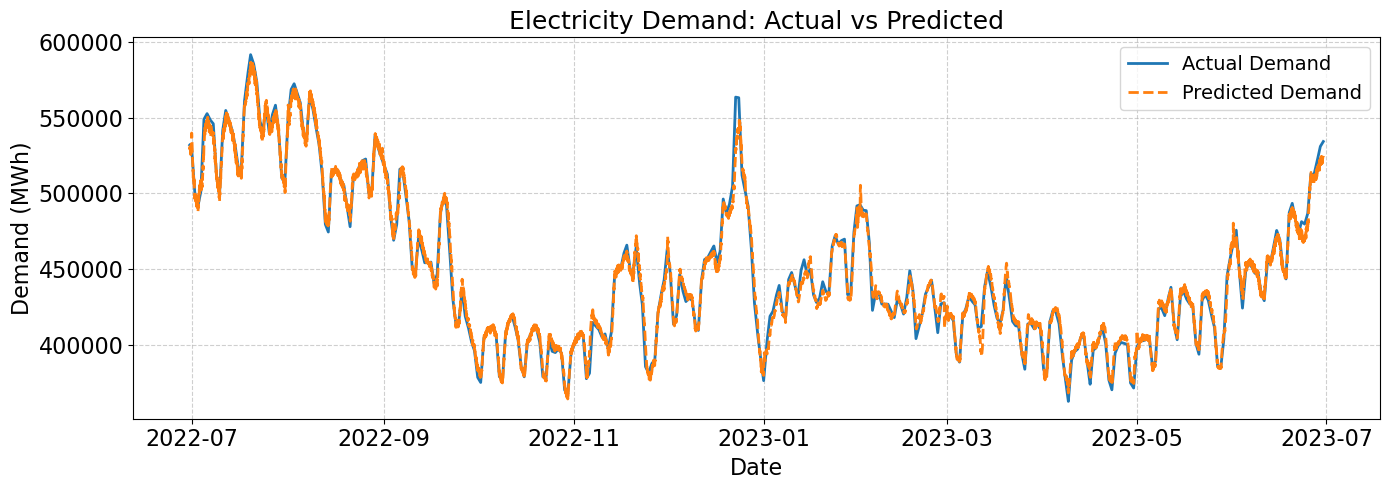

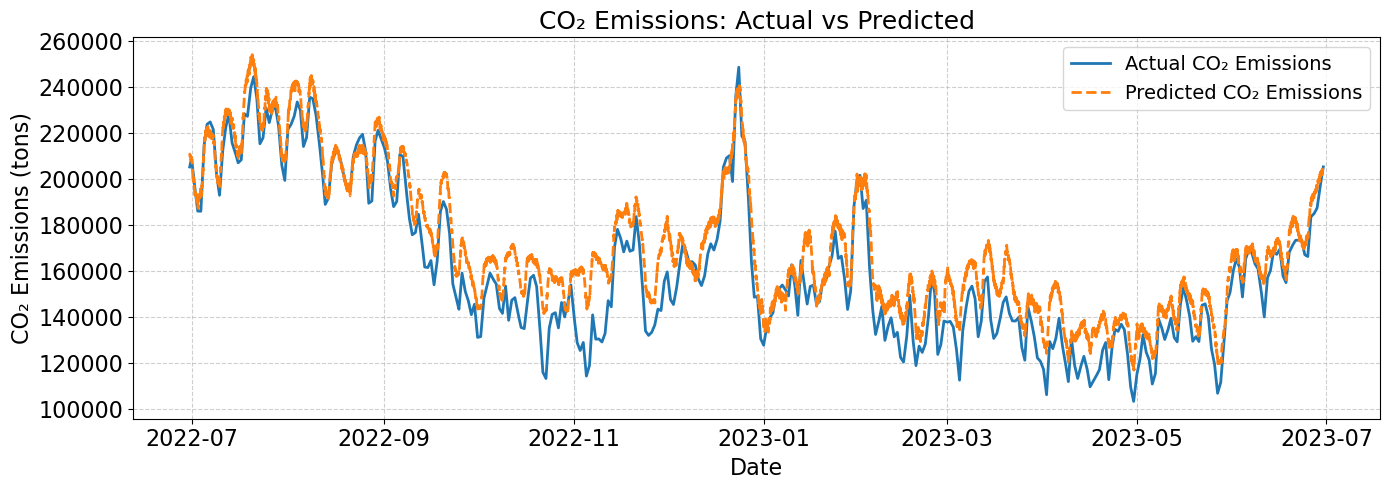

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


features = national[[
    'Hour', 'Month', 'DayOfWeek', 'Is_Weekend', 'DayOfYear', 'WeekOfYear',
    'Season_Autumn', 'Season_Spring', 'Season_Summer', 'Season_Winter',
    'Renewable_Pct', 'Fossil_Pct',
    'Demand_Prev_Hour', 'Demand_Yesterday_Same_Hour', 'Demand_Last_Week_Same_Hour',
    'Rolling_Mean_3H', 'Rolling_Mean_24H'
]]
targets = national[['Demand', 'CO2_Total_Emissions']]

# Scale
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(features)
y_scaled = scaler_y.fit_transform(targets)

# Create sequences
def create_sequences(X, y, lookback=30):
    Xs, ys, y_actual = [], [], []
    for i in range(lookback, len(X)):
        Xs.append(X[i-lookback:i])
        ys.append(y[i])
        y_actual.append(i)  # save index for inverse mapping
    return np.array(Xs), np.array(ys), np.array(y_actual)

X_seq, y_seq, y_idx = create_sequences(X_scaled, y_scaled)

# -----------------------
# Step 2: Train/Test Split
# -----------------------
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]
test_idx = y_idx[split:]

# -----------------------
# Step 3: Train LSTM
# -----------------------
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(2)  # single-step prediction (2 outputs)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=2, batch_size=68)

# -----------------------
# Step 4: Predict and Inverse Transform
# -----------------------
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

# -----------------------
# Step 5: Plot Predictions vs Actuals
# -----------------------
dates = national.index[test_idx]

# Plot 1: Electricity Demand
plt.figure(figsize=(14, 5))
plt.plot(dates, y_true[:, 0], label='Actual Demand', linewidth=2)
plt.plot(dates, y_pred[:, 0], label='Predicted Demand', linewidth=2, linestyle='--')
plt.title('Electricity Demand: Actual vs Predicted', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Demand (MWh)', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Plot 2: CO₂ Emissions
plt.figure(figsize=(14, 5))
plt.plot(dates, y_true[:, 1], label='Actual CO₂ Emissions', linewidth=2)
plt.plot(dates, y_pred[:, 1], label='Predicted CO₂ Emissions', linewidth=2, linestyle='--')
plt.title('CO₂ Emissions: Actual vs Predicted', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('CO₂ Emissions (tons)', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Define Mean Absolute Percentage Error
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# -----------------------
# Step 6: Evaluation Metrics
# -----------------------

# Demand Metrics
rmse_demand = np.sqrt(mean_squared_error(y_true[:, 0], y_pred[:, 0]))
mae_demand = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
mape_demand = mean_absolute_percentage_error(y_true[:, 0], y_pred[:, 0])

# CO₂ Metrics
rmse_co2 = np.sqrt(mean_squared_error(y_true[:, 1], y_pred[:, 1]))
mae_co2 = mean_absolute_error(y_true[:, 1], y_pred[:, 1])
mape_co2 = mean_absolute_percentage_error(y_true[:, 1], y_pred[:, 1])

# -----------------------
# Print Results
# -----------------------
print("✅ Electricity Demand Forecast Accuracy:")
print(f"RMSE: {rmse_demand:.2f}, MAE: {mae_demand:.2f}, MAPE: {mape_demand:.2f}%")

print("\n✅ CO₂ Emissions Forecast Accuracy:")
print(f"RMSE: {rmse_co2:.2f}, MAE: {mae_co2:.2f}, MAPE: {mape_co2:.2f}%")


✅ Electricity Demand Forecast Accuracy:
RMSE: 4897.73, MAE: 3534.76, MAPE: 0.78%

✅ CO₂ Emissions Forecast Accuracy:
RMSE: 12905.94, MAE: 10618.72, MAPE: 7.34%


In [8]:
df = pd.read_csv(r"C:\Users\featue_engg_data1.csv")
#df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Hour,Demand,Net_Generation,Total_Interchange,Forecasted_Demand,Coal_Gen,Gas_Gen,Nuclear_Gen,Hydro_Gen,...,Season_Summer,Season_Winter,Demand_Prev_Hour,Demand_Yesterday_Same_Hour,Demand_Last_Week_Same_Hour,Rolling_Mean_3H,Rolling_Mean_24H,Total_Gen,Renewable_Pct,Fossil_Pct
0,2018-07-01 17:00:00,12.5,28976.042,21138.304,-6528.677,28386.220,8.764,7725.951,2261.073,3089.741,...,1,0,31560.368,97906.322,30623.583,52909.261,42604.509,17521.203,42.950,44.145
1,2018-07-01 18:00:00,12.5,29065.500,21217.885,-6554.521,28486.010,8.792,7761.917,2261.062,3110.594,...,1,0,19035.781,36973.722,30187.366,26585.677,41847.195,17577.073,42.927,44.209
2,2018-07-01 19:00:00,12.5,29154.958,21297.467,-6580.365,28585.800,8.819,7797.882,2261.052,3131.446,...,1,0,120405.354,28886.583,96196.009,60325.969,45629.697,17632.943,42.904,44.273
3,2018-07-01 20:00:00,12.5,29244.417,21377.049,-6606.208,28685.590,8.847,7833.847,2261.042,3152.299,...,1,0,8629.271,31655.750,35642.181,23684.576,48609.446,17688.812,42.881,44.337
4,2018-07-01 21:00:00,12.5,29333.875,21456.630,-6632.052,28785.380,8.875,7869.812,2261.031,3173.151,...,1,0,31562.326,29065.500,8211.854,30046.873,49142.567,17744.682,42.858,44.400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525055,2023-06-29 20:00:00,12.5,64967.778,65025.979,58.042,65732.083,8989.486,27552.910,4647.181,32.896,...,1,0,40554.444,14324.708,37711.542,67747.671,49409.849,46077.069,10.607,79.307
525056,2023-06-29 21:00:00,12.5,64902.135,64963.474,61.177,65699.302,8993.729,27593.401,4647.292,33.224,...,1,0,31739.526,22046.601,65821.128,37511.137,46137.266,46106.208,10.566,79.354
525057,2023-06-29 22:00:00,12.5,64836.493,64900.969,64.312,65666.521,8997.972,27633.892,4647.403,33.552,...,1,0,15892.381,31801.521,21450.109,39168.139,45454.091,46135.347,10.526,79.401
525058,2023-06-29 23:00:00,12.5,64770.851,64838.464,67.448,65633.740,9002.215,27674.384,4647.514,33.880,...,1,0,22263.507,97828.229,41419.396,42477.179,39779.804,46164.486,10.485,79.448


In [9]:
def simulate_renewable_scenarios_national(national, display_name="National"):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.preprocessing import MinMaxScaler
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense
    import tensorflow as tf
    import numpy as np
    import pandas as pd

    print(f"\n🌱 Simulating renewable energy scenarios for {display_name}...")
    np.random.seed(42)
    tf.random.set_seed(42)
    lookback = 15

    national = national.copy()
    national.index = pd.to_datetime(national.index)

    features = national[[
        'Hour', 'Month', 'DayOfWeek', 'Is_Weekend', 'DayOfYear', 'WeekOfYear',
        'Season_Autumn', 'Season_Spring', 'Season_Summer', 'Season_Winter',
        'Renewable_Pct', 'Fossil_Pct',
        'Demand_Prev_Hour', 'Demand_Yesterday_Same_Hour', 'Demand_Last_Week_Same_Hour',
        'Rolling_Mean_3H', 'Rolling_Mean_24H'
    ]]
    targets = national[['Demand', 'CO2_Total_Emissions']]

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(features)
    y_scaled = scaler_y.fit_transform(targets)

    max_rows = 20000
    X_scaled = X_scaled[-max_rows:]
    y_scaled = y_scaled[-max_rows:]
    dates_all = national.index[-max_rows:]

    def create_sequences(X, y, dates, lookback):
        Xs, ys, idxs = [], [], []
        for i in range(lookback, len(X)):
            Xs.append(X[i - lookback:i])
            ys.append(y[i])
            idxs.append(dates[i])
        return np.array(Xs), np.array(ys), idxs

    X_seq, y_seq, idx_seq = create_sequences(X_scaled, y_scaled, dates_all, lookback)

    model = Sequential([
        LSTM(64, input_shape=(X_seq.shape[1], X_seq.shape[2])),
        Dense(2)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_seq, y_seq, epochs=2, batch_size=64, verbose=0)

    future_dates = pd.date_range(start=national.index[-1] + pd.Timedelta(days=1), periods=365, freq='D')

    base_df = pd.DataFrame({
        'Date': future_dates,
        'Hour': 12,
        'Month': future_dates.month,
        'DayOfWeek': future_dates.dayofweek,
        'Is_Weekend': future_dates.dayofweek.isin([5, 6]).astype(int),
        'DayOfYear': future_dates.dayofyear,
        'WeekOfYear': future_dates.isocalendar().week,
        'Season_Winter': ((future_dates.month <= 2) | (future_dates.month == 12)).astype(int),
        'Season_Spring': future_dates.month.isin([3, 4, 5]).astype(int),
        'Season_Summer': future_dates.month.isin([6, 7, 8]).astype(int),
        'Season_Autumn': future_dates.month.isin([9, 10, 11]).astype(int),
    })

    for col in ['Demand_Prev_Hour', 'Demand_Yesterday_Same_Hour', 'Demand_Last_Week_Same_Hour',
                'Rolling_Mean_3H', 'Rolling_Mean_24H']:
        base_df[col] = national[col].mean()

    renew_base = national['Renewable_Pct'].mean()
    fossil_base = national['Fossil_Pct'].mean()

    scenarios = {
        "Base": (renew_base, fossil_base),
        "+10% Renewables": (min(renew_base + 10, 100), max(fossil_base - 10, 0)),
        "+20% Renewables": (min(renew_base + 20, 100), max(fossil_base - 20, 0)),
        "+30% Renewables": (min(renew_base + 30, 100), max(fossil_base - 30, 0)),
    }

    predictions_future = {}
    for name, (renew, fossil) in scenarios.items():
        df_copy = base_df.copy()
        df_copy['Renewable_Pct'] = renew
        df_copy['Fossil_Pct'] = fossil
        df_copy = df_copy[features.columns]
        scaled = scaler_X.transform(df_copy)

        input_seq = X_scaled[-lookback:].copy()
        forecast_scaled = []
        for i in range(365):
            input_seq = np.vstack([input_seq[1:], scaled[i]])
            pred = model.predict(input_seq.reshape(1, lookback, X_scaled.shape[1]), verbose=0)[0]
            forecast_scaled.append(pred)
        forecast = scaler_y.inverse_transform(forecast_scaled)
        predictions_future[name] = forecast[:, 1]

    recent_df = features.tail(365).copy()
    base_emissions_hist = scaler_y.inverse_transform(y_scaled[-365:])[:, 1]
    predictions_hist = {}

    for name, (renew, fossil) in scenarios.items():
        mod_df = recent_df.copy()
        mod_df['Renewable_Pct'] = renew
        mod_df['Fossil_Pct'] = fossil
        scaled_mod = scaler_X.transform(mod_df)
        input_seq = X_scaled[-(365 + lookback):-365]

        forecast_scaled = []
        for i in range(365):
            input_seq = np.vstack([input_seq[1:], scaled_mod[i]])
            pred = model.predict(input_seq.reshape(1, lookback, X_scaled.shape[1]), verbose=0)[0]
            forecast_scaled.append(pred)
        forecast = scaler_y.inverse_transform(forecast_scaled)
        predictions_hist[name] = forecast[:, 1]

    plt.figure(figsize=(14, 5))
    plt.plot(dates_all[-365:], base_emissions_hist, label='Actual CO₂ Emissions', color='black', linewidth=2)
    plt.plot(dates_all[-365:], predictions_hist["+30% Renewables"], label='Simulated CO₂ (+30% Renewables)', color='green', linestyle='--', linewidth=2)
    plt.title(f"{display_name}: Historical Simulation of CO₂ Emissions with Renewables", fontsize=18)
    plt.xlabel("Date", fontsize=16)
    plt.ylabel("CO₂ Emissions (tons)", fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    base_scaled = MinMaxScaler().fit_transform(predictions_future["Base"].reshape(-1, 1)).flatten()
    sim_scaled = MinMaxScaler().fit_transform(predictions_future["+30% Renewables"].reshape(-1, 1)).flatten()

    plt.figure(figsize=(14, 5))
    plt.plot(future_dates, base_scaled, label="Original CO₂ Emissions", color='orange', linewidth=2)
    plt.plot(future_dates, sim_scaled, label="Simulated CO₂ (+30% Renewables)", color='green', linestyle='--', linewidth=2)
    plt.title(f"{display_name}: Forecasted CO₂ Emissions with 30% Renewables", fontsize=18)
    plt.xlabel("Date", fontsize=16)
    plt.ylabel("CO₂ Emissions (Scaled)", fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    return {
        'Region': display_name,
        'Historical_Base_CO2': np.sum(base_emissions_hist),
        'Historical_30%Renew_CO2': np.sum(predictions_hist["+30% Renewables"]),
        'Future_Base_CO2': np.sum(predictions_future["Base"]),
        'Future_30%Renew_CO2': np.sum(predictions_future["+30% Renewables"])
    }



🌱 Simulating renewable energy scenarios for US National...


C:\Users\rosem\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


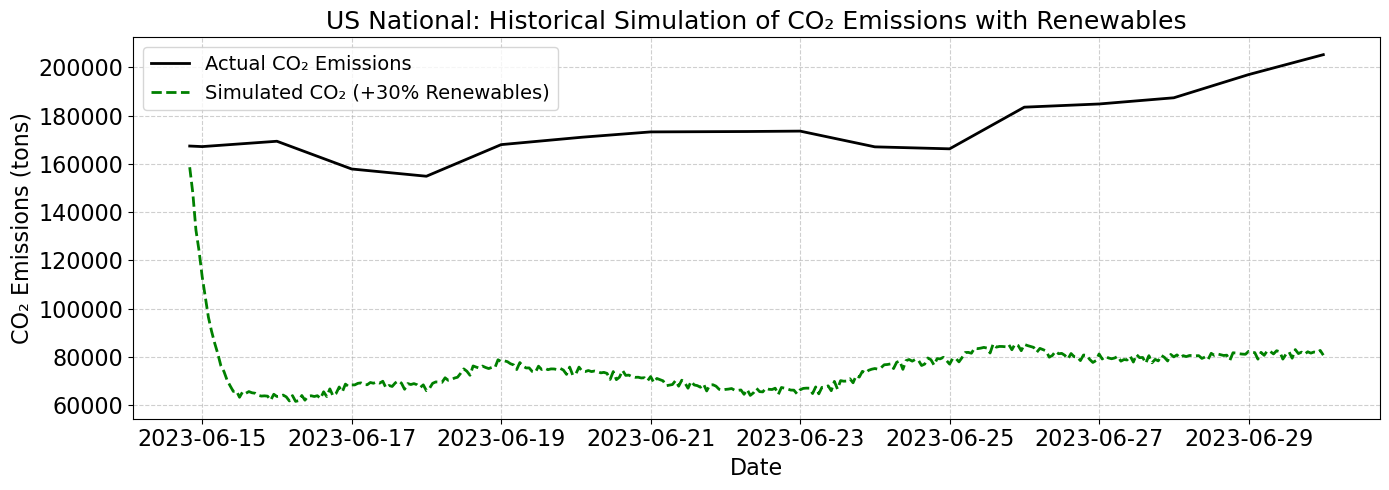

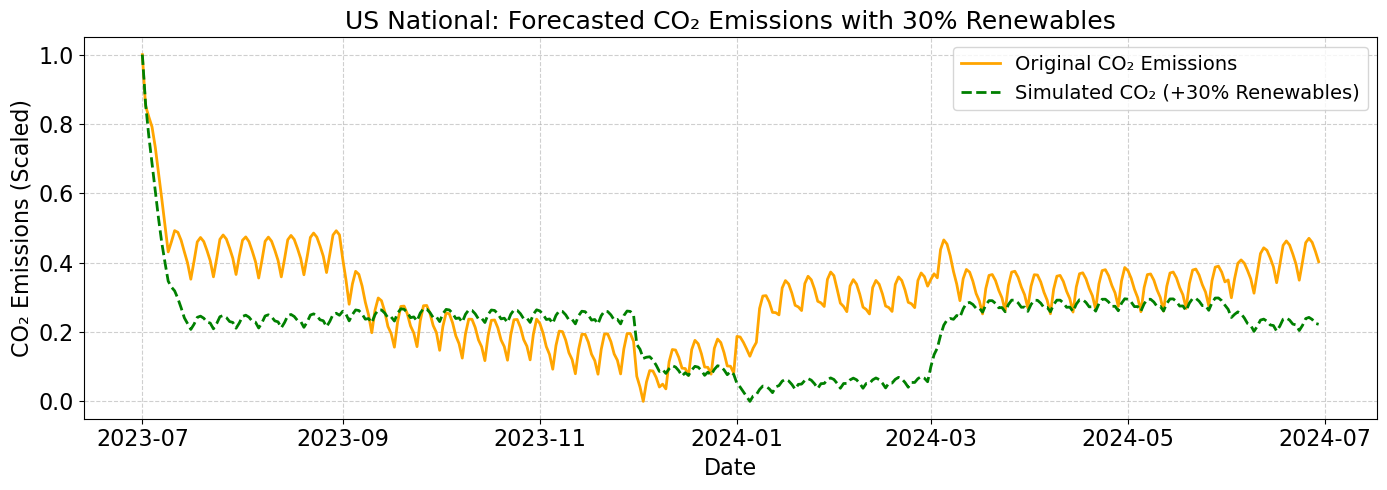

In [10]:
national_results = simulate_renewable_scenarios_national(national, display_name="US National")

In [11]:
if isinstance(national_results, dict):
    national_results = [national_results]

results_df = pd.DataFrame(national_results)

In [12]:
# Calculate CO₂ reduction percent for historical and future
results_df['Historical_CO2_Reduction_Percent'] = (
    (results_df['Historical_Base_CO2'] - results_df['Historical_30%Renew_CO2']) / results_df['Historical_Base_CO2']
) * 100

results_df['Future_CO2_Reduction_Percent'] = (
    (results_df['Future_Base_CO2'] - results_df['Future_30%Renew_CO2']) / results_df['Future_Base_CO2']
) * 100


In [14]:
summary = results_df[['Region', 'Historical_CO2_Reduction_Percent', 'Future_CO2_Reduction_Percent']].copy()
summary['Historical_CO2_Reduction_Percent'] = summary['Historical_CO2_Reduction_Percent'].map('{:.2f}%'.format)
summary['Future_CO2_Reduction_Percent'] = summary['Future_CO2_Reduction_Percent'].map('{:.2f}%'.format)

print(summary.to_string(index=False))

     Region Historical_CO2_Reduction_Percent Future_CO2_Reduction_Percent
US National                           56.89%                       64.50%


C:\Users\rosem\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3282/3282 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step


C:\Users\rosem\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3282/3282 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step


C:\Users\rosem\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3282/3282 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step


C:\Users\rosem\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3282/3282 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step


C:\Users\rosem\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3282/3282 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step
  Renewable Penetration Increase  Avg. Predicted CO₂ Emissions        MAE  \
0                            10%                  10459.821866  21.178669   
1                            20%                  10411.892070  32.699950   
2                            30%                  10327.649340  20.656736   
3                            40%                  10285.496068  48.494366   
4                            50%                  10179.259478  26.613804   

        RMSE  MAPE (%)  
0  63.040251  0.240531  
1  73.114548  0.337613  
2  60.695127  0.261115  
3  82.254931  0.563674  
4  68.037823  0.333979  


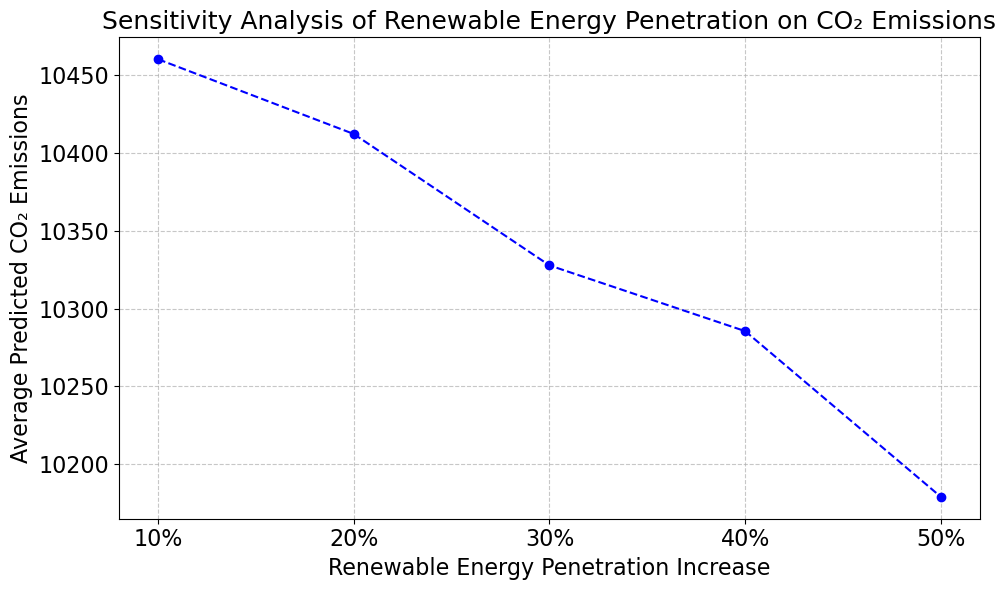

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load dataset
df = pd.read_csv(r"C:\Users\rosem\Downloads\FINAL_PROJECT_WORKS\CSV_files\featue_engg_data1.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Function for sensitivity analysis with evaluation metrics
def sensitivity_analysis_with_metrics(df, renewable_shares=[0.1,0.2,0.3,0.4,0.5], lookback=30):
    results = []
    scaler = MinMaxScaler()

    data = df[['Demand', 'CO2_Total_Emissions', 'Hydro_Gen', 'Solar_Gen']].copy()

    for share in renewable_shares:
        modified_data = data.copy()
        
        # Adjust renewable generation
        modified_data['Renewable_Gen'] = (modified_data['Hydro_Gen'] + modified_data['Solar_Gen']) * (1 + share)
        modified_data['Renewable_Gen'] = np.clip(modified_data['Renewable_Gen'], None, modified_data['Demand'])
        
        # Adjust emissions proportionally
        fossil_gen_reduction = modified_data['Demand'] - modified_data['Renewable_Gen']
        original_fossil_gen = modified_data['Demand'] - (data['Hydro_Gen'] + data['Solar_Gen'])
        emission_factor = (data['CO2_Total_Emissions'] / original_fossil_gen).mean()
        modified_data['CO2_Total_Emissions'] = fossil_gen_reduction * emission_factor

        # Scale data
        scaled_data = scaler.fit_transform(modified_data[['Demand', 'CO2_Total_Emissions', 'Renewable_Gen']])

        # Prepare LSTM dataset
        X, y = [], []
        for i in range(lookback, len(scaled_data)):
            X.append(scaled_data[i-lookback:i])
            y.append(scaled_data[i, 1])  # CO2 emissions as target
        X, y = np.array(X), np.array(y)

        # Train-test split
        split_idx = int(len(X) * 0.8)
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]

        # Define and train LSTM model
        model = Sequential()
        model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')

        model.fit(X_train, y_train, epochs=2, batch_size=64, verbose=0)

        # Predict emissions
        predictions = model.predict(X_test)

        # Inverse scaling
        predictions_rescaled = scaler.inverse_transform(
            np.hstack((np.zeros((len(predictions), 1)),
                       predictions,
                       np.zeros((len(predictions), 1))))
        )[:, 1]

        y_test_rescaled = scaler.inverse_transform(
            np.hstack((np.zeros((len(y_test), 1)),
                       y_test.reshape(-1, 1),
                       np.zeros((len(y_test), 1))))
        )[:, 1]

        # Calculate metrics
        mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
        rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
        mape = np.mean(np.abs((y_test_rescaled - predictions_rescaled) / y_test_rescaled)) * 100

        # Save metrics and average emissions
        results.append({
            'Renewable Penetration Increase': f'{int(share*100)}%',
            'Avg. Predicted CO₂ Emissions': predictions_rescaled.mean(),
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape
        })

    return pd.DataFrame(results)

# Perform sensitivity analysis
renewable_shares = [0.1, 0.2, 0.3, 0.4, 0.5]
result_df = sensitivity_analysis_with_metrics(df, renewable_shares)

# Display results table
print(result_df)

# Save results table as CSV (optional)
result_df.to_csv("sensitivity_analysis_results.csv", index=False)

plt.figure(figsize=(10, 6))
plt.plot(result_df['Renewable Penetration Increase'],
         result_df['Avg. Predicted CO₂ Emissions'],
         marker='o', linestyle='--', color='blue')

plt.xlabel('Renewable Energy Penetration Increase', fontsize=16)
plt.ylabel('Average Predicted CO₂ Emissions', fontsize=16)
plt.title('Sensitivity Analysis of Renewable Energy Penetration on CO₂ Emissions', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [16]:
result_df

,Renewable Penetration Increase,Avg. Predicted CO₂ Emissions,MAE,RMSE,MAPE (%)
0,10%,10459.821866,21.178669,63.040251,0.240531
1,20%,10411.892070,32.699950,73.114548,0.337613
2,30%,10327.649340,20.656736,60.695127,0.261115
3,40%,10285.496068,48.494366,82.254931,0.563674
4,50%,10179.259478,26.613804,68.037823,0.333979


C:\Users\rosem\AppData\Local\Temp\ipykernel_3644\2903815073.py:37: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, plot_type="dot")


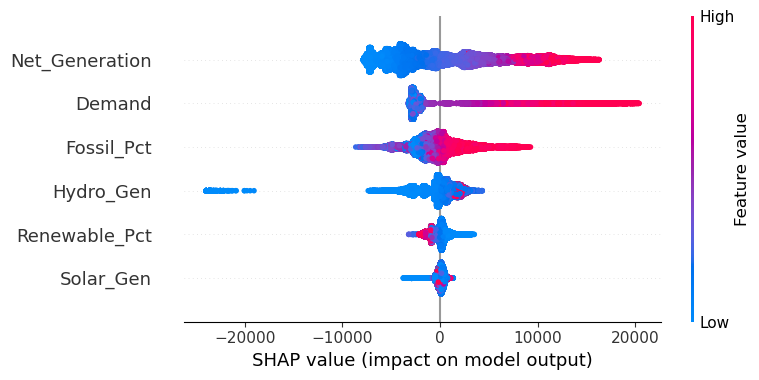

In [52]:
import pandas as pd
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Load your dataset

# Define features and target based on your updated column list
features = ['Net_Generation',
    'Demand', 'Hydro_Gen', 'Solar_Gen',
    'Renewable_Pct', 'Fossil_Pct']
target = 'CO2_Total_Emissions'

# Extract features and target
X = df[features]
y = df[target]

# Scale features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train model
model = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1)
model.fit(X_train, y_train)

# SHAP analysis
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# SHAP summary plot
shap.summary_plot(shap_values, X_test, plot_type="dot")

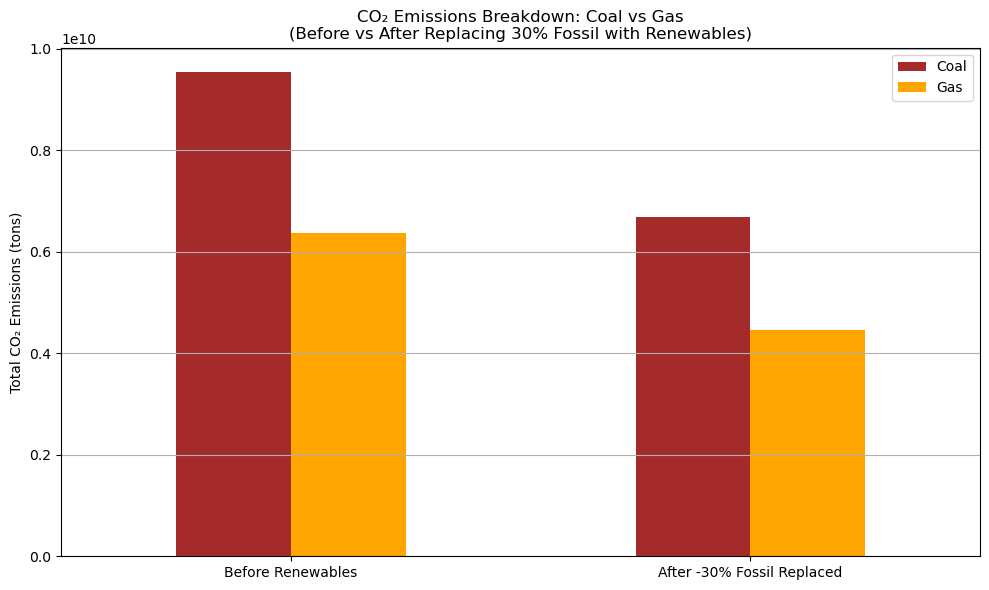

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv(r"C:\Users\rosem\Downloads\FINAL_PROJECT_WORKS\CSV_files\featue_engg_data1.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Only consider rows with fossil generation
df = df[(df['Coal_Gen'] + df['Gas_Gen']) > 0].copy()

# === Step 1: Baseline Emissions ===
df['CO2_Coal_Baseline'] = df['Coal_Gen'] * df['CO2_Factor_Coal']
df['CO2_Gas_Baseline'] = df['Gas_Gen'] * df['CO2_Factor_Gas']
baseline_coal = df['CO2_Coal_Baseline'].sum()
baseline_gas = df['CO2_Gas_Baseline'].sum()

# === Step 2: Apply renewable substitution (NOT generation increase)
renewable_penetration = 0.3
df['Total_Fossil_Gen'] = df['Coal_Gen'] + df['Gas_Gen']

# Assume 30% of fossil demand is now met by renewables
df['Remaining_Fossil_Gen'] = df['Total_Fossil_Gen'] * (1 - renewable_penetration)

# Redistribute remaining fossil generation proportionally
df['Coal_Share'] = df['Coal_Gen'] / df['Total_Fossil_Gen']
df['Gas_Share'] = df['Gas_Gen'] / df['Total_Fossil_Gen']
df['Coal_Gen_New'] = df['Remaining_Fossil_Gen'] * df['Coal_Share']
df['Gas_Gen_New'] = df['Remaining_Fossil_Gen'] * df['Gas_Share']

# === Step 3: Recalculate Emissions
df['CO2_Coal_New'] = df['Coal_Gen_New'] * df['CO2_Factor_Coal']
df['CO2_Gas_New'] = df['Gas_Gen_New'] * df['CO2_Factor_Gas']
new_coal = df['CO2_Coal_New'].sum()
new_gas = df['CO2_Gas_New'].sum()

# === Step 4: Create Comparison Plot
emissions_df = pd.DataFrame({
    'Coal': [baseline_coal, new_coal],
    'Gas': [baseline_gas, new_gas]
}, index=['Before Renewables', f'After -{int(renewable_penetration * 100)}% Fossil Replaced'])

emissions_df.plot(kind='bar', figsize=(10,6), color=['brown', 'orange'])
plt.title("CO₂ Emissions Breakdown: Coal vs Gas\n(Before vs After Replacing 30% Fossil with Renewables)")
plt.ylabel("Total CO₂ Emissions (tons)")
plt.xticks(rotation=0)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()